In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

In [3]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

# TODO: set the GPU you want to use
gpu_n = 0

torch.set_default_dtype(torch.float64)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Simplified Model**

Chord Types: These are initially unknown and could represent major, minor, diminished, augmented, etc. We will infer these from the data.

### **Generative Process**:

Chord Type Selection (c): Randomly choose a chord type.
Number of Notes (n): Randomly decide the number of notes in the chord.
Pitch Generation: For each note, sample its pitch from the chosen chord type's distribution.

### **Inference**:

Observed Variables: Number of notes (n) and pitches (p).
Unobserved Variables: Chord type (c) and chord type profiles (ϕ).

### **Amortization**:

Use a neural network to link variables and infer distributions across the dataset, rather than on a per-chord basis.

## Step 1: Model

In [7]:
def simplified_chord_model(npcs, data, pobserve=0.5, **kwargs):
    # parameters priors:
    # choose the distribution of chord types
    p_chord = pyro.sample('p_chord', Dirichlet(0.5 * torch.ones(npcs, device=device)))

    # sampling the data:
    nchords = len(data)
    with pyro.plate('data', nchords) as ind:
        # pick a chord type for each chord (now unknown, to be inferred)
        chord_type = pyro.sample('chord_type', Categorical(p_chord))

        # pick a number of notes for each chord based on the chord type
        # using a simple prior for now, can be replaced with actual data or a more informed prior
        nnotes = 1 + pyro.sample('n', Poisson(torch.tensor(3., device=device))).int()

        # sample the pitches for each note in the chord
        # this is a simplified version where we don't distinguish between chord tones and ornaments
        pitches = pyro.sample('pitches', Dirichlet(0.5 * torch.ones(npcs, device=device)))

        # The actual observed data would go here, but since we're sampling everything,
        # we don't have observed data in this simplified model.
        # In a real-world scenario, you would replace this with the actual observed pitches.

    # Return the sampled chord types and pitches
    return {'chord_type': chord_type, 'pitches': pitches}

## Step 2: Guide for Inference


In [8]:
def simplified_chord_guide(npcs, data, **kwargs):
    nchords = len(data)

    params_p_chord = pyro.param('params_p_chord',
                                torch.ones(npcs, device=device),
                                constraint=constraints.positive)
    pyro.sample('p_chord', Dirichlet(params_p_chord))

    params_pitches = pyro.param('params_pitches',
                                torch.ones([nchords, npcs], device=device),
                                constraint=constraints.positive)
    with pyro.plate('chord_pitches', nchords):
        pyro.sample('pitches', Dirichlet(params_pitches))

    # For now, we're assuming it's simply a Poisson distribution.
    # Use Gamma as the conjugate prior for Poisson's rate parameter.
    alpha_rate_notes = pyro.param('alpha_rate_notes', torch.tensor(3., device=device),
                                  constraint=constraints.positive)
    beta_rate_notes = pyro.param('beta_rate_notes', torch.tensor(1., device=device),
                                 constraint=constraints.positive)
    pyro.sample('rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))


## Step 3: Data and Conditioning
**Data Format**


In [9]:
def simplified_chord_tensor(notes):
    """Takes a list of notes as pitch classes and returns a vector of counts."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)  # Assuming utils.fifth_to_index simply shifts the pitch class to the index
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["notes"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    # Subtracting 1 as the original code suggests notes include a rest, or similar, which is not a note
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [10]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': list(grp.fifth)}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplfied_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [11]:
def get_init_params(df, npcs):
    init = dict()
    # The prior for the distribution of chords can be estimated from the label frequencies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size(), device=device) + 0.5

    # For the pitches, since we're not distinguishing between chordtones and ornaments,
    # we accumulate all counts into a single distribution.
    pitch_counts = torch.zeros(npcs, device=device) + 0.5
    for fifth, grp in df.groupby('fifth'):
        pitch_counts[utils.fifth_to_index(fifth)] += grp.fifth.count()
    init['pitches'] = pitch_counts

    # Other initial parameters related to the counts of chords and notes will remain the same.
    chord_sizes = df.groupby('chordid').size() - 1
    init['sum_chords'] = torch.tensor(sum(chord_sizes) + 3., device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes) + 1., device=device)

    return init

After inferring the parameters we save them for easier inspection and reuse.



In [12]:
def save_params(params, chordtypes, name):
    torch.save(params, path.join("results", name+'.pt'))
    with open(path.join("results", name+'.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key,val in params.items()},
                   'chordtypes': chordtypes},
                  f)

## Step 4: Inference

In [18]:
def infer_posteriors(npcs, obs, init, chordtypes,
                     nsteps=5000, subsamples=10000, particles=1,
                     plot_loss=True, save_as=None):
    # optimize the parameters of the guide
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)  # set every time for independent reproducibility
    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=simplified_chord_guide,
                         optim=pyro.optim.Adam({"lr": 0.01, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO(num_particles=particles))

    # set up histories for the loss and some of the parameters
    losses = np.zeros(nsteps)
    param_history = {name: np.zeros(nsteps) for name in ['alpha_rate_notes', 'beta_rate_notes']}

    # run the optimization
    for i in tqdm.trange(nsteps):
        # update parameters and record loss
        # Make sure to pass both 'npcs' and 'obs' as arguments
        losses[i] = svi.step(npcs, obs, subsamples=subsamples, init=init)

        # record values of some parameters
        ps = pyro.get_param_store()
        for (name, value) in ps.items():
            if name in param_history:
                param_history[name][i] = value.cpu().item()

    # plot the loss
    if plot_loss:
        plt.figure()
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title(f"loss ({save_as})")
        plt.show(block=False)
        print("loss variance (last 100 steps):", losses[-100:].var())

    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, chordtypes, save_as)

    return params, param_history


## Step 5: Plotting

In [14]:
# histories

# several parameters
def plot_params_history(name, ax, history):
    df = pd.DataFrame(history)
    df.plot(ax=ax)
    ax.set_title(f"history ({name})")
    ax.set_xlabel("iteration")

# single parameter
def plot_param_history(name, ax, root_history, ylabel):
    ax.plot(root_history)
    ax.set_xlabel("iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} ({name})")

# all parameters
# def plot_histories(name, param_history, root_history, harm_history):
#    fig, ax = plt.subplots(1,3, figsize=(9,3))
#    plot_params_history(name, ax[0], param_history)
#    plot_param_history(name, ax[1], root_history, 'root parameters')
#    plot_param_history(name, ax[2], harm_history, 'chord-type parameters')
#    fig.tight_layout()
#    plt.show(block=False)

def plot_histories(name, param_history):
    fig, ax = plt.subplots(1, len(param_history), figsize=(3 * len(param_history), 3))
    if len(param_history) == 1:  # Ensure ax is iterable
        ax = [ax]
    for i, (param_name, history) in enumerate(param_history.items()):
        plot_param_history(name, ax[i], history, param_name)
    fig.tight_layout()
    plt.show(block=False)

In [15]:
# posterior

# The posteriors related to 'p_is_chordtone' and note probabilities have been removed.
def plot_posteriors(name, params, chordtypes, rate_range=(0, 10)):
    fig, ax = plt.subplots(2, 1, figsize=(9, 6), constrained_layout=True)

    plot_note_rate(name, ax[0], params, lower=rate_range[0], upper=rate_range[1])
    # If 'params_p_harmony' still exists and refers to the chord type probabilities:
    plot_chord_type_dist(name, ax[1], params, chordtypes)

    plt.show(block=False)

# This function has been revised to only plot the 'rate_notes' parameter.
def plot_note_rate(name, ax, params, lower=0, upper=10):
    alpha = params['alpha_rate_notes']
    beta = params['beta_rate_notes']
    x = np.linspace(lower, upper, 200)
    y = stats.gamma.pdf(x, alpha, scale=1/beta)
    ax.plot(x, y)
    ax.set_xlabel('rate_notes')
    ax.set_title(f'note rate distribution ({name})')

# This function plots the distribution of chord types if 'params_p_harmony' is still relevant.
def plot_chord_type_dist(name, ax, params, labels):
    alphas = params['params_p_harmony']
    ax.barh(np.arange(len(alphas)), alphas, tick_label=labels)
    ax.invert_yaxis()
    ax.set_xlabel("Probability")
    ax.set_title(f'Chord-type distribution ({name})')

# 2. Experiment

In [16]:
# DCML Corpus
# The DCML corpus is a collection of classical pieces with elaborate harmonic annotations.

# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


100%|██████████| 350/350 [00:08<00:00, 42.97it/s]


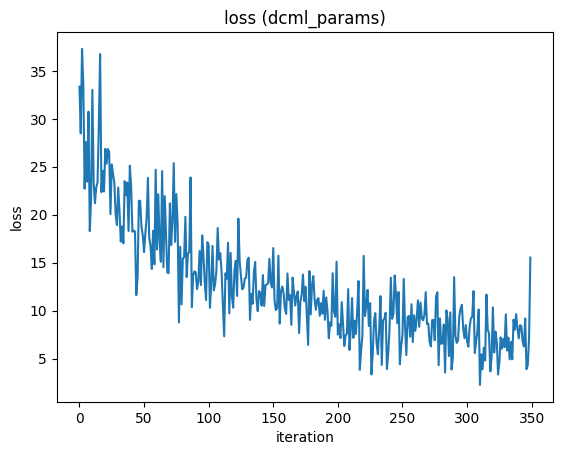

loss variance (last 100 steps): 5.80405817665606


In [19]:
# run the optimization
dcml_params, dhist = infer_posteriors(npcs, dcml_obs, dcml_init, dcml_chordtypes,
                                      nsteps=350, subsamples=None, particles=1,
                                      save_as="dcml_params")

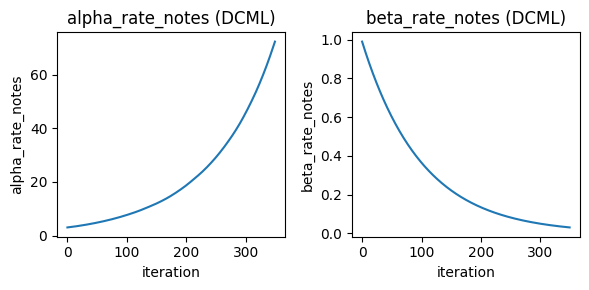

In [20]:
# plot the histories of the parameters to check convergence
plot_histories("DCML", dhist)

KeyError: ignored

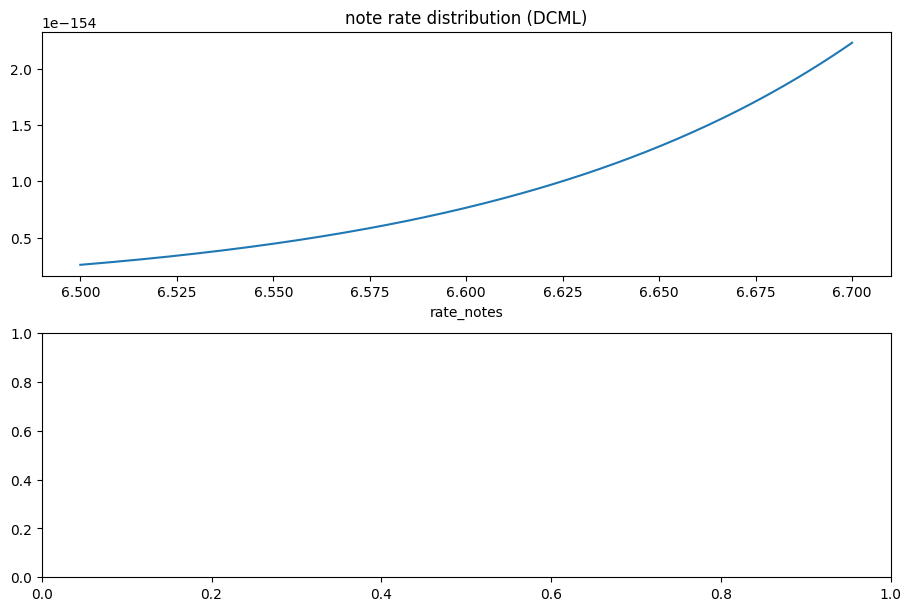

In [21]:
# plot the posterior distributions of the parameters
plot_posteriors("DCML", dcml_params, dcml_chordtypes, rate_range=(6.5, 6.7))